In [ ]:
#| default_exp models.lstm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LSTM

The Long Short-Term Memory Recurrent Neural Network (`LSTM`), uses a multilayer `LSTM` encoder and an `MLP` decoder. It builds upon the LSTM-cell that improves the exploding and vanishing gradients of classic `RNN`'s. This network has been extensively used in sequential prediction tasks like language modeling, phonetic labeling, and forecasting. The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{LSTM}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>-[Jeffrey L. Elman (1990). "Finding Structure in Time".](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1)<br>-[Haşim Sak, Andrew Senior, Françoise Beaufays (2014). "Long Short-Term Memory Based Recurrent Neural Network Architectures for Large Vocabulary Speech Recognition."](https://arxiv.org/abs/1402.1128)<br>

![Figure 1. Long Short-Term Memory Cell.](imgs_models/lstm.png)

In [ ]:
#| hide
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_model import BaseModel
from neuralforecast.common._modules import MLP

In [ ]:
#| export
class LSTM(BaseModel):
    """ LSTM

    LSTM encoder, with MLP decoder.
    The network has `tanh` or `relu` non-linearities, it is trained using 
    ADAM stochastic gradient descent. The network accepts static, historic 
    and future exogenous data.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `inference_input_size`: int, maximum sequence length for truncated inference. Default -1 uses all history.<br>
    `encoder_n_layers`: int=2, number of layers for the LSTM.<br>
    `encoder_hidden_size`: int=200, units for the LSTM's hidden state size.<br>
    `encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within LSTM units.<br>
    `encoder_dropout`: float=0., dropout regularization applied to LSTM outputs.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    # Class attributes
    SAMPLING_TYPE = 'recurrent'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True
    MULTIVARIATE = False    # If the model produces multivariate forecasts (True) or univariate (False)
    RECURRENT = True        # If the model produces forecasts recursively (True) or direct (False)

    def __init__(self,
                 h: int,
                 input_size: int,
                 encoder_n_layers: int = 2,
                 encoder_hidden_size: int = 200,
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'robust',
                 random_seed = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):
        super(LSTM, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            **trainer_kwargs
        )

        # LSTM
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_bias = encoder_bias
        self.encoder_dropout = encoder_dropout
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        # LSTM input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size

        # Instantiate model
        self.rnn_state = None
        self.hist_encoder = nn.LSTM(input_size=input_encoder,
                                    hidden_size=self.encoder_hidden_size,
                                    num_layers=self.encoder_n_layers,
                                    bias=self.encoder_bias,
                                    dropout=self.encoder_dropout,
                                    batch_first=True)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size * h + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y']                         # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']                          # [B, seq_len, F]
        hist_exog     = windows_batch['hist_exog']                          # [B, seq_len, X]
        stat_exog     = windows_batch['stat_exog']                          # [B, S]

        # Concatenate y, historic and static inputs              
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)    # [B, seq_len, 1] + [B, seq_len, X] -> [B, seq_len, 1 + X]

        if self.stat_exog_size > 0:
            # print(encoder_input.shape)
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)        # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)    # [B, seq_len, 1 + X] + [B, seq_len, S] -> [B, seq_len, 1 + X + S]

        if self.futr_exog_size > 0:
            encoder_input = torch.cat((encoder_input, futr_exog), dim=2)    # [B, seq_len, 1 + X + S] + [B, seq_len, F] -> [B, seq_len, 1 + X + S + F]

        # RNN forward
        if self.maintain_state:
            rnn_state = self.rnn_state
        else:
            rnn_state = None
        
        hidden_state, rnn_state = self.hist_encoder(encoder_input, 
                                                         rnn_state)    # [B, seq_len, rnn_hidden_state]
        if self.maintain_state:
            self.rnn_state = rnn_state

        # Context adapter
        context = self.context_adapter(hidden_state)                        # [B, seq_len, rnn_hidden_state] -> [B, seq_len, context_size * h]

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)               # [B, seq_len, context_size * h] + [B, seq_len, F] = [B, seq_len, context_size * h + F]

        # Final forecast
        output = self.mlp_decoder(context)                                  # [B, seq_len, context_size * h + F] -> [B, seq_len, n_output]
        
        return output

In [ ]:
show_doc(LSTM)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/lstm.py#L19){target="_blank" style="float:right; font-size:smaller"}

### LSTM

>      LSTM (h:int, input_size:int, encoder_n_layers:int=2,
>            encoder_hidden_size:int=200, encoder_bias:bool=True,
>            encoder_dropout:float=0.0, context_size:int=10,
>            decoder_hidden_size:int=200, decoder_layers:int=2,
>            futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>            exclude_insample_y=False, loss=MAE(), valid_loss=None,
>            max_steps:int=1000, learning_rate:float=0.001,
>            num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>            val_check_steps:int=100, batch_size=32,
>            valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>            inference_windows_batch_size=1024, start_padding_enabled=False,
>            step_size:int=1, scaler_type:str='robust', random_seed=1,
>            num_workers_loader=0, drop_last_loader=False, optimizer=None,
>            optimizer_kwargs=None, lr_scheduler=None, lr_scheduler_kwargs=None,
>            **trainer_kwargs)

*LSTM

LSTM encoder, with MLP decoder.
The network has `tanh` or `relu` non-linearities, it is trained using 
ADAM stochastic gradient descent. The network accepts static, historic 
and future exogenous data.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`inference_input_size`: int, maximum sequence length for truncated inference. Default -1 uses all history.<br>
`encoder_n_layers`: int=2, number of layers for the LSTM.<br>
`encoder_hidden_size`: int=200, units for the LSTM's hidden state size.<br>
`encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within LSTM units.<br>
`encoder_dropout`: float=0., dropout regularization applied to LSTM outputs.<br>
`context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
`decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>*

In [ ]:
show_doc(LSTM.fit, name='LSTM.fit')

---

### LSTM.fit

>      LSTM.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(LSTM.predict, name='LSTM.predict')

---

### LSTM.predict

>      LSTM.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                    **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## Usage Example

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

In [ ]:

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[LSTM(h=12, 
                 input_size=24,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                #  loss=MAE(),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=200,
                 futr_exog_list=['y_[lag12]'],
                 #hist_exog_list=['y_[lag12]'],
                 stat_exog_list=['airline1'],
                 )
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic)
Y_hat_df = nf.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | DistributionLoss | 5     
1 | padder_train    | ConstantPad1d    | 0     
2 | scaler          | TemporalNorm     | 0     
3 | hist_encoder    | LSTM             | 200 K 
4 | context_adapter | Linear           | 15.5 K
5 | mlp_decoder     | MLP              | 15.9 K
-----------------------------------------------------
231 K     Trainable params
5         Non-trainable params
231 K     Total params
0.926     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 33.33it/s, v_num=3697, train_loss_step=3.670, train_loss_epoch=3.670]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, v_num=3697, train_loss_step=3.670, train_loss_epoch=3.670]


c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:374: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:428: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

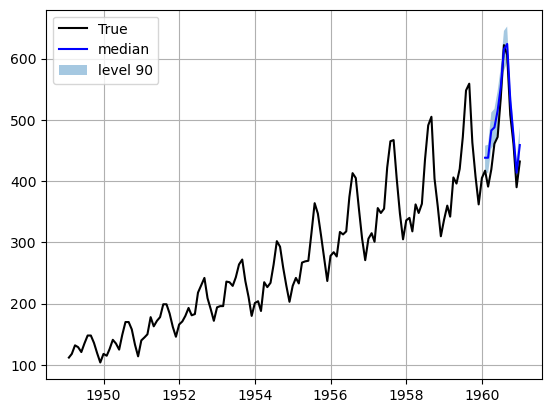

In [ ]:
# Plots
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['ds'], plot_df['LSTM'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['LSTM-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['LSTM-lo-90'][-12:].values, 
                 y2=plot_df['LSTM-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()